# Encoder-Decoder Models & Differential Geometry of Latent Space

This notebook explores **Variational Autoencoders (VAEs)** on MNIST through the lens of **differential geometry**. We treat the latent space as a Riemannian manifold and analyze:

- **Pullback metric** induced by the decoder
- **Geodesics** — shortest paths on the latent manifold  
- **Curvature** — how the manifold bends in different regions
- **Fisher Information** — statistical geometry of the generative model

## 1. Import Libraries & Load MNIST

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LATENT_DIM = 2  # 2D for visualization
BATCH_SIZE = 1024
EPOCHS = 30

# Load MNIST
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

print(f"Device: {device}, Dataset size: {len(train_data)}")

Device: cuda, Dataset size: 60000


/home/mp/anaconda3/envs/unf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Variational Autoencoder Architecture

The VAE learns a probabilistic mapping between data $x$ and latent codes $z$:
- **Encoder**: $q_\phi(z|x) = \mathcal{N}(\mu_\phi(x), \sigma_\phi(x)^2 I)$
- **Decoder**: $p_\theta(x|z)$ reconstructs images from latent codes
- **Reparameterization**: $z = \mu + \sigma \odot \epsilon$, where $\epsilon \sim \mathcal{N}(0, I)$

In [2]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.latent_dim = latent_dim
        
        # Encoder: x -> (mu, logvar)
        self.encoder = nn.Sequential(
            nn.Linear(784, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU()
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        
        # Decoder: z -> x
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256), nn.ReLU(),
            nn.Linear(256, 512), nn.ReLU(),
            nn.Linear(512, 784), nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder(x.view(-1, 784))
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """ELBO = Reconstruction + β * KL divergence"""
    recon = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta * kl

model = VAE(LATENT_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(f"VAE parameters: {sum(p.numel() for p in model.parameters()):,}")

VAE parameters: 1,068,820


In [3]:
# Training loop
model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for x, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False):
        x = x.to(device)
        recon, mu, logvar = model(x)
        loss = vae_loss(recon, x, mu, logvar)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}: Loss = {total_loss/len(train_data):.4f}")

model.eval()

Epoch 1: Loss = 244.1349


Epoch 2: Loss = 187.4375


Epoch 3: Loss = 176.3388


Epoch 4: Loss = 170.4236


Epoch 5: Loss = 166.4350


Epoch 6: Loss = 163.4988


Epoch 7: Loss = 161.0955


Epoch 8: Loss = 158.9771


Epoch 9: Loss = 157.3537


Epoch 10: Loss = 156.0046


Epoch 11: Loss = 155.0556


Epoch 12: Loss = 153.9854


Epoch 13: Loss = 153.1951


Epoch 14: Loss = 152.5020


Epoch 15: Loss = 151.9710


Epoch 16: Loss = 150.9943


Epoch 17: Loss = 150.3429


Epoch 18: Loss = 149.9104


Epoch 19: Loss = 149.2631


Epoch 20: Loss = 148.7542


Epoch 21: Loss = 148.2664


Epoch 22: Loss = 147.8705


Epoch 23: Loss = 147.4681


Epoch 24: Loss = 147.1032


Epoch 25: Loss = 146.6423


Epoch 26: Loss = 146.2919


Epoch 27: Loss = 146.0077


Epoch 28: Loss = 145.6043


Epoch 29: Loss = 145.3917


Epoch 30: Loss = 145.1042


VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=256, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

## 3. Riemannian Metric on Latent Space

The decoder $f_\theta: \mathbb{R}^d \to \mathbb{R}^D$ maps low-dimensional latent codes to high-dimensional images. This induces a **pullback metric**:

$$G(z) = J(z)^T J(z)$$

where $J(z) = \frac{\partial f_\theta(z)}{\partial z} \in \mathbb{R}^{D \times d}$ is the Jacobian. This metric measures how distances in latent space correspond to perceptual distances in image space.

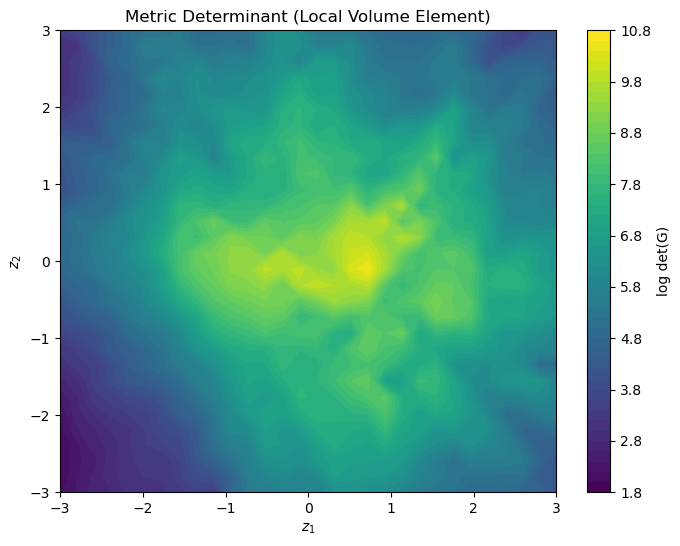

In [4]:
def compute_jacobian(model, z):
    """Compute Jacobian of decoder: J[i,j] = ∂f_i/∂z_j"""
    z = z.clone().requires_grad_(True)
    output = model.decode(z)
    jacobian = []
    for i in range(output.shape[-1]):
        grad = torch.autograd.grad(output[..., i].sum(), z, create_graph=True)[0]
        jacobian.append(grad)
    return torch.stack(jacobian, dim=-2)  # (batch, 784, latent_dim)

def compute_metric(model, z):
    """Compute pullback metric G(z) = J^T J"""
    J = compute_jacobian(model, z)
    return torch.bmm(J.transpose(-2, -1), J)  # (batch, d, d)

# Visualize metric determinant (measures local volume distortion)
def plot_metric_field(model, grid_size=30, extent=3):
    model.eval()
    zs = torch.linspace(-extent, extent, grid_size)
    Z1, Z2 = torch.meshgrid(zs, zs, indexing='ij')
    z_grid = torch.stack([Z1.flatten(), Z2.flatten()], dim=1).to(device)
    
    # Compute metric in batches (needs gradients for Jacobian)
    det_G = []
    for z in z_grid.split(100):
        G = compute_metric(model, z)
        det_G.append(torch.linalg.det(G).detach().cpu())
    det_G = torch.cat(det_G).reshape(grid_size, grid_size)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(Z1.numpy(), Z2.numpy(), torch.log(det_G + 1e-8).numpy(), levels=50, cmap='viridis')
    plt.colorbar(label='log det(G)')
    plt.xlabel('$z_1$'); plt.ylabel('$z_2$')
    plt.title('Metric Determinant (Local Volume Element)')
    plt.show()

plot_metric_field(model)

## 4. Geodesics in Latent Manifold

Geodesics are curves of minimal length on the manifold. They satisfy the geodesic equation:

$$\ddot{z}^k + \Gamma^k_{ij} \dot{z}^i \dot{z}^j = 0$$

where $\Gamma^k_{ij} = \frac{1}{2} G^{kl}\left(\partial_i G_{jl} + \partial_j G_{il} - \partial_l G_{ij}\right)$ are the **Christoffel symbols**.

In [12]:
def compute_christoffel(model, z, eps=1e-4):
    """Compute Christoffel symbols via finite differences of the metric"""
    d = z.shape[-1]
    G = compute_metric(model, z)
    G_inv = torch.linalg.inv(G)
    
    # Compute metric derivatives
    dG = torch.zeros(z.shape[0], d, d, d, device=z.device)
    for i in range(d):
        z_plus = z.clone()
        z_minus = z.clone()
        z_plus[:, i] += eps
        z_minus[:, i] -= eps
        G_plus = compute_metric(model, z_plus)
        G_minus = compute_metric(model, z_minus)
        dG[:, i] = (G_plus - G_minus) / (2 * eps)
    
    # Christoffel: Γ^k_ij = 0.5 * G^{kl} (∂_i G_{jl} + ∂_j G_{il} - ∂_l G_{ij})
    Gamma = torch.zeros(z.shape[0], d, d, d, device=z.device)
    for k in range(d):
        for i in range(d):
            for j in range(d):
                for l in range(d):
                    Gamma[:, k, i, j] += 0.5 * G_inv[:, k, l] * (
                        dG[:, i, j, l] + dG[:, j, i, l] - dG[:, l, i, j]
                    )
    return Gamma

def geodesic_shooting(model, z0, z1, n_steps=20, n_iter=100, lr=0.1):
    """Find geodesic between z0 and z1 using energy minimization"""
    # Initialize with linear interpolation
    t = torch.linspace(0, 1, n_steps, device=z0.device).unsqueeze(1)
    path = z0 + t * (z1 - z0)
    path = path.clone().requires_grad_(True)
    
    optimizer = torch.optim.Adam([path], lr=lr)
    
    for _ in range(n_iter):
        optimizer.zero_grad()
        
        # Compute energy: E = ∫ g_ij dz^i/dt dz^j/dt dt
        energy = 0
        for i in range(n_steps - 1):
            z_mid = (path[i] + path[i+1]) / 2
            G = compute_metric(model, z_mid.unsqueeze(0))[0]
            dz = path[i+1] - path[i]
            energy += dz @ G @ dz
        
        energy.backward()
        
        # Keep endpoints fixed
        path.grad[0] = 0
        path.grad[-1] = 0
        optimizer.step()
    
    return path.detach()

print("Geodesic computation ready.")

Geodesic computation ready.


## 5. Latent Space Curvature

The **Gaussian curvature** (in 2D) or **scalar curvature** quantifies how the manifold deviates from flat Euclidean space:

$$K = \frac{R_{1212}}{\det(G)}$$

High curvature regions indicate rapid changes in the decoder mapping — often at class boundaries.

Computing curvature...
Computing density estimation...


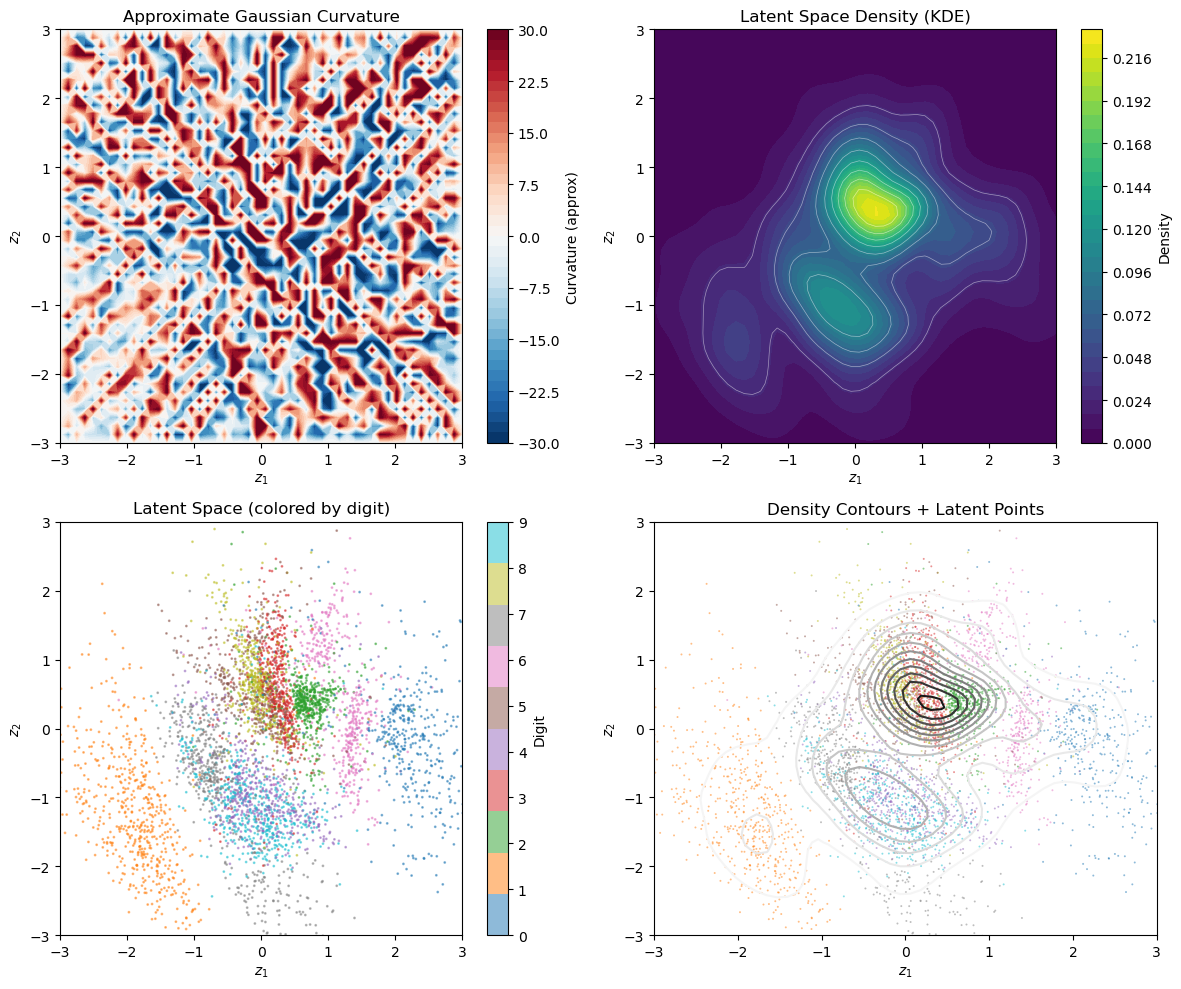

In [13]:
from scipy import stats

def compute_curvature_fast(model, z_grid, eps=0.05):
    """Fast approximate curvature using metric determinant variation"""
    # Curvature approximated by Laplacian of log(det(G))
    # This correlates with true curvature and is much faster
    n = int(np.sqrt(len(z_grid)))
    
    det_G = []
    for z in z_grid.split(100):
        G = compute_metric(model, z)
        det_G.append(torch.linalg.det(G).detach().cpu())
    det_G = torch.cat(det_G).reshape(n, n)
    
    log_det = torch.log(det_G + 1e-8)
    
    # Laplacian as curvature proxy (finite differences)
    K = torch.zeros_like(log_det)
    K[1:-1, 1:-1] = (
        log_det[2:, 1:-1] + log_det[:-2, 1:-1] + 
        log_det[1:-1, 2:] + log_det[1:-1, :-2] - 
        4 * log_det[1:-1, 1:-1]
    ) / (eps ** 2)
    
    return K

# Plot curvature field (faster version)
def plot_curvature(model, grid_size=50, extent=3):
    model.eval()
    zs = torch.linspace(-extent, extent, grid_size)
    Z1, Z2 = torch.meshgrid(zs, zs, indexing='ij')
    z_grid = torch.stack([Z1.flatten(), Z2.flatten()], dim=1).to(device)
    
    print("Computing curvature...")
    K = compute_curvature_fast(model, z_grid, eps=zs[1]-zs[0])
    K = torch.clamp(K, -30, 30)  # Clip extreme values
    
    # Load test data for latent visualization
    test_data = datasets.MNIST('./data', train=False, transform=transform)
    test_loader = DataLoader(test_data, batch_size=5000, shuffle=False)
    x_test, y_test = next(iter(test_loader))
    with torch.no_grad():
        mu, _ = model.encode(x_test.to(device))
    mu = mu.cpu().numpy()
    
    # Compute KDE for latent density contours
    print("Computing density estimation...")
    kde = stats.gaussian_kde(mu.T)
    density = kde(np.vstack([Z1.numpy().ravel(), Z2.numpy().ravel()])).reshape(grid_size, grid_size)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Curvature heatmap (filled contour)
    im = axes[0, 0].contourf(Z1.numpy(), Z2.numpy(), K.numpy(), levels=50, cmap='RdBu_r')
    plt.colorbar(im, ax=axes[0, 0], label='Curvature (approx)')
    axes[0, 0].set_xlabel('$z_1$'); axes[0, 0].set_ylabel('$z_2$')
    axes[0, 0].set_title('Approximate Gaussian Curvature')
    
    # Latent density contour plot
    im_density = axes[0, 1].contourf(Z1.numpy(), Z2.numpy(), density, levels=30, cmap='viridis')
    axes[0, 1].contour(Z1.numpy(), Z2.numpy(), density, levels=10, colors='white', linewidths=0.5, alpha=0.5)
    plt.colorbar(im_density, ax=axes[0, 1], label='Density')
    axes[0, 1].set_xlabel('$z_1$'); axes[0, 1].set_ylabel('$z_2$')
    axes[0, 1].set_title('Latent Space Density (KDE)')
    axes[0, 1].set_xlim(-extent, extent); axes[0, 1].set_ylim(-extent, extent)
    
    # Latent points colored by digit
    scatter = axes[1, 0].scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='tab10', alpha=0.5, s=1)
    plt.colorbar(scatter, ax=axes[1, 0], label='Digit')
    axes[1, 0].set_xlabel('$z_1$'); axes[1, 0].set_ylabel('$z_2$')
    axes[1, 0].set_title('Latent Space (colored by digit)')
    axes[1, 0].set_xlim(-extent, extent); axes[1, 0].set_ylim(-extent, extent)
    
    # Density contours + latent points overlay
    axes[1, 1].contour(Z1.numpy(), Z2.numpy(), density, levels=12, cmap='Greys', linewidths=1.5)
    axes[1, 1].scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='tab10', alpha=0.5, s=2, edgecolors='none')
    axes[1, 1].set_xlabel('$z_1$'); axes[1, 1].set_ylabel('$z_2$')
    axes[1, 1].set_title('Density Contours + Latent Points')
    axes[1, 1].set_xlim(-extent, extent); axes[1, 1].set_ylim(-extent, extent)
    
    plt.tight_layout()
    plt.show()

plot_curvature(model)

## 6. Geodesic vs Euclidean Interpolation

Linear interpolation in latent space often crosses low-density regions, producing unrealistic intermediates. **Geodesic interpolation** follows the manifold's natural geometry, staying on the data manifold.

Interpolating: 7 → 0
Computing metric field...


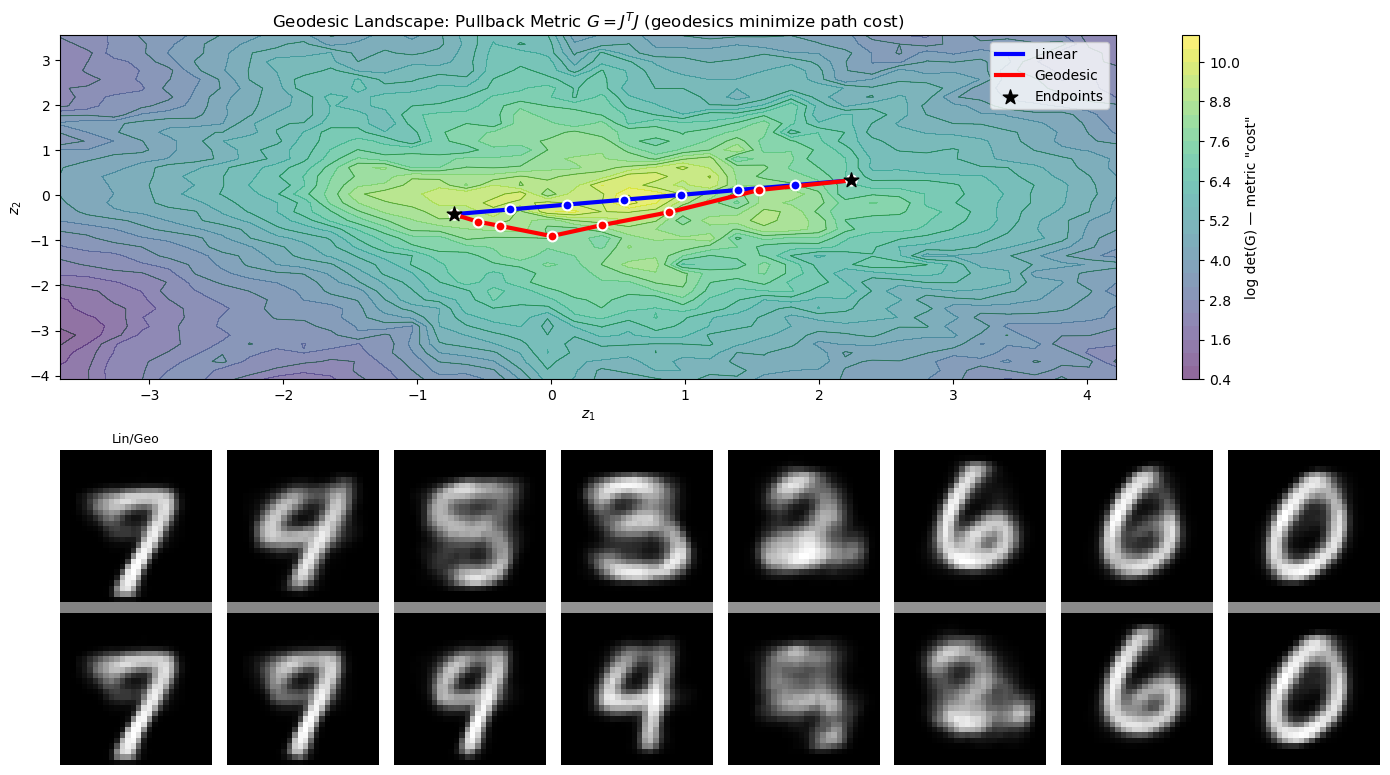

In [14]:
def geodesic_shooting_fast(model, z0, z1, n_steps=8, n_iter=20, lr=0.2):
    """Fast geodesic approximation with fewer iterations
    
    Note: n_steps here controls optimization resolution, not output resolution.
    Use interpolate_path() to get more points along the final geodesic.
    """
    # Use fixed optimization resolution for stability
    opt_steps = min(n_steps, 12)  # Don't optimize with too many points
    
    t = torch.linspace(0, 1, opt_steps, device=z0.device).unsqueeze(1)
    path = (z0 + t * (z1 - z0)).clone().requires_grad_(True)
    
    # Scale iterations with complexity
    actual_iter = max(n_iter, opt_steps * 5)
    optimizer = torch.optim.Adam([path], lr=lr)
    
    for _ in range(actual_iter):
        optimizer.zero_grad()
        # Compute all midpoints at once
        midpoints = (path[:-1] + path[1:]) / 2
        G = compute_metric(model, midpoints)
        dz = path[1:] - path[:-1]
        # Energy = sum of dz^T G dz for each segment
        energy = (dz.unsqueeze(1) @ G @ dz.unsqueeze(2)).sum()
        energy.backward()
        path.grad[0] = 0  # Fix endpoints
        path.grad[-1] = 0
        optimizer.step()
    
    optimized_path = path.detach()
    
    # If we need more points, interpolate along the optimized path
    if n_steps > opt_steps:
        optimized_path = interpolate_path(optimized_path, n_steps)
    
    return optimized_path

def interpolate_path(path, n_points):
    """Interpolate a path to have n_points using cubic spline"""
    from scipy.interpolate import CubicSpline
    
    path_np = path.cpu().numpy()
    t_old = np.linspace(0, 1, len(path_np))
    t_new = np.linspace(0, 1, n_points)
    
    # Fit cubic spline to each dimension
    cs = CubicSpline(t_old, path_np)
    new_path = cs(t_new)
    
    return torch.tensor(new_path, dtype=torch.float32, device=path.device)

def compare_interpolations(model, idx1=0, idx2=100, n_steps=8):
    """Compare geodesic vs linear interpolation between two digits"""
    test_data = datasets.MNIST('./data', train=False, transform=transform)
    x1, y1 = test_data[idx1]
    x2, y2 = test_data[idx2]
    
    with torch.no_grad():
        z1, _ = model.encode(x1.unsqueeze(0).to(device))
        z2, _ = model.encode(x2.unsqueeze(0).to(device))
    
    print(f"Interpolating: {y1} → {y2}")
    
    # Linear interpolation
    t = torch.linspace(0, 1, n_steps).unsqueeze(1).to(device)
    linear_path = z1 + t * (z2 - z1)
    
    # Geodesic interpolation (now handles any n_steps properly)
    geodesic_path = geodesic_shooting_fast(model, z1.squeeze(), z2.squeeze(), n_steps=n_steps)
    
    # Decode both paths
    with torch.no_grad():
        linear_imgs = model.decode(linear_path).cpu().view(-1, 28, 28)
        geodesic_imgs = model.decode(geodesic_path).cpu().view(-1, 28, 28)
    
    # Get latent embeddings for background scatter
    test_loader = DataLoader(test_data, batch_size=3000, shuffle=False)
    x_test, y_test = next(iter(test_loader))
    with torch.no_grad():
        mu_test, _ = model.encode(x_test.to(device))
    mu_test = mu_test.cpu().numpy()
    
    linear_np = linear_path.cpu().numpy()
    geodesic_np = geodesic_path.cpu().numpy()
    
    # Set extent for metric grid
    x_min = min(linear_np[:, 0].min(), geodesic_np[:, 0].min(), mu_test[:, 0].min()) - 0.5
    x_max = max(linear_np[:, 0].max(), geodesic_np[:, 0].max(), mu_test[:, 0].max()) + 0.5
    y_min = min(linear_np[:, 1].min(), geodesic_np[:, 1].min(), mu_test[:, 1].min()) - 0.5
    y_max = max(linear_np[:, 1].max(), geodesic_np[:, 1].max(), mu_test[:, 1].max()) + 0.5
    
    # Compute metric field (the actual "landscape" for geodesics)
    print("Computing metric field...")
    grid_size = 40
    xx = torch.linspace(x_min, x_max, grid_size)
    yy = torch.linspace(y_min, y_max, grid_size)
    XX, YY = torch.meshgrid(xx, yy, indexing='ij')
    z_grid = torch.stack([XX.flatten(), YY.flatten()], dim=1).to(device)
    
    det_G = []
    for z in z_grid.split(100):
        G = compute_metric(model, z)
        det_G.append(torch.linalg.det(G).detach().cpu())
    det_G = torch.cat(det_G).reshape(grid_size, grid_size)
    log_det_G = torch.log(det_G + 1e-8).numpy()
    
    # Create figure with paths visualization and decoded images
    fig = plt.figure(figsize=(14, 8))
    
    # Top: Latent space with paths and METRIC contours (the geodesic landscape!)
    ax_latent = fig.add_subplot(2, 1, 1)
    
    # Plot metric as the "landscape" - this is what geodesics minimize over!
    im = ax_latent.contourf(XX.numpy(), YY.numpy(), log_det_G, levels=30, cmap='viridis', alpha=0.6)
    ax_latent.contour(XX.numpy(), YY.numpy(), log_det_G, levels=15, colors='darkgreen', linewidths=0.6, alpha=0.5)
    plt.colorbar(im, ax=ax_latent, label='log det(G) — metric "cost"')
    
    # Plot linear path
    ax_latent.plot(linear_np[:, 0], linear_np[:, 1], 'b-', linewidth=3, label='Linear', zorder=5)
    ax_latent.scatter(linear_np[:, 0], linear_np[:, 1], c='blue', s=50, zorder=6, edgecolors='white', linewidths=1.5)
    
    # Plot geodesic path
    ax_latent.plot(geodesic_np[:, 0], geodesic_np[:, 1], 'r-', linewidth=3, label='Geodesic', zorder=5)
    ax_latent.scatter(geodesic_np[:, 0], geodesic_np[:, 1], c='red', s=50, zorder=6, edgecolors='white', linewidths=1.5)
    
    # Mark start and end points
    ax_latent.scatter([linear_np[0, 0], linear_np[-1, 0]], [linear_np[0, 1], linear_np[-1, 1]], 
                      c='black', s=120, marker='*', zorder=7, label='Endpoints')
    
    ax_latent.set_xlabel('$z_1$'); ax_latent.set_ylabel('$z_2$')
    ax_latent.set_title(f'Geodesic Landscape: Pullback Metric $G = J^T J$ (geodesics minimize path cost)')
    ax_latent.legend(loc='upper right')
    ax_latent.set_xlim(x_min, x_max)
    ax_latent.set_ylim(y_min, y_max)
    
    # Bottom: Decoded images (show subset if too many)
    show_steps = min(n_steps, 12)
    indices = np.linspace(0, n_steps - 1, show_steps, dtype=int)
    
    for i, idx in enumerate(indices):
        ax_lin = fig.add_subplot(2, show_steps, show_steps + i + 1)
        # Stack linear (top half) and geodesic (bottom half) in same cell
        combined = np.vstack([linear_imgs[idx].numpy(), np.ones((2, 28)) * 0.5, geodesic_imgs[idx].numpy()])
        ax_lin.imshow(combined, cmap='gray')
        ax_lin.axis('off')
        if i == 0:
            ax_lin.set_title('Lin/Geo', fontsize=9)
    
    plt.tight_layout()
    plt.show()

# Run with first 3 and first 8 found
compare_interpolations(model, idx1=0, idx2=3)

In [18]:
def plot_3d_geodesic_landscape(model, idx1=0, idx2=3, n_steps=8):
    """Interactive 3D visualization of the metric landscape with geodesic and linear paths"""
    import plotly.graph_objects as go
    from scipy.interpolate import RegularGridInterpolator
    
    test_data = datasets.MNIST('./data', train=False, transform=transform)
    x1, y1 = test_data[idx1]
    x2, y2 = test_data[idx2]
    
    with torch.no_grad():
        z1, _ = model.encode(x1.unsqueeze(0).to(device))
        z2, _ = model.encode(x2.unsqueeze(0).to(device))
    
    print(f"3D Landscape: {y1} → {y2}")
    
    # Linear interpolation
    t = torch.linspace(0, 1, n_steps).unsqueeze(1).to(device)
    linear_path = z1 + t * (z2 - z1)
    
    # Geodesic interpolation (now properly handles any n_steps)
    geodesic_path = geodesic_shooting_fast(model, z1.squeeze(), z2.squeeze(), n_steps=n_steps)
    
    linear_np = linear_path.cpu().numpy()
    geodesic_np = geodesic_path.cpu().numpy()
    
    # Compute extent with padding
    x_min = min(linear_np[:, 0].min(), geodesic_np[:, 0].min()) - 1.0
    x_max = max(linear_np[:, 0].max(), geodesic_np[:, 0].max()) + 1.0
    y_min = min(linear_np[:, 1].min(), geodesic_np[:, 1].min()) - 1.0
    y_max = max(linear_np[:, 1].max(), geodesic_np[:, 1].max()) + 1.0
    
    # Compute metric field for surface
    print("Computing metric surface...")
    grid_size = 50
    xx = np.linspace(x_min, x_max, grid_size)
    yy = np.linspace(y_min, y_max, grid_size)
    XX, YY = np.meshgrid(xx, yy, indexing='ij')
    z_grid = torch.tensor(np.stack([XX.flatten(), YY.flatten()], axis=1), dtype=torch.float32).to(device)
    
    det_G = []
    for z in z_grid.split(100):
        G = compute_metric(model, z)
        det_G.append(torch.linalg.det(G).detach().cpu())
    det_G = torch.cat(det_G).reshape(grid_size, grid_size).numpy()
    log_det_G = np.log(det_G + 1e-8)
    
    # Get heights for paths on the surface
    interp = RegularGridInterpolator((xx, yy), log_det_G, method='linear', bounds_error=False, fill_value=None)
    linear_heights = interp(linear_np)
    geodesic_heights = interp(geodesic_np)
    
    elevation_offset = 0.2
    
    # Create plotly figure
    fig = go.Figure()
    
    # Add surface
    fig.add_trace(go.Surface(
        x=XX, y=YY, z=log_det_G,
        colorscale='Viridis',
        opacity=0.8,
        showscale=True,
        colorbar=dict(title='log det(G)', x=1.02),
        name='Metric Landscape'
    ))
    
    # Add linear path
    fig.add_trace(go.Scatter3d(
        x=linear_np[:, 0], y=linear_np[:, 1], z=linear_heights + elevation_offset,
        mode='lines+markers',
        line=dict(color='blue', width=8),
        marker=dict(size=4, color='blue', line=dict(color='white', width=1)),
        name='Linear'
    ))
    
    # Add geodesic path
    fig.add_trace(go.Scatter3d(
        x=geodesic_np[:, 0], y=geodesic_np[:, 1], z=geodesic_heights + elevation_offset,
        mode='lines+markers',
        line=dict(color='red', width=8),
        marker=dict(size=4, color='red', line=dict(color='white', width=1)),
        name='Geodesic'
    ))
    
    # Add endpoint markers
    fig.add_trace(go.Scatter3d(
        x=[linear_np[0, 0], linear_np[-1, 0]],
        y=[linear_np[0, 1], linear_np[-1, 1]],
        z=[linear_heights[0] + elevation_offset, linear_heights[-1] + elevation_offset],
        mode='markers',
        marker=dict(size=12, color='black', symbol='diamond'),
        name='Endpoints'
    ))
    
    fig.update_layout(
        title=dict(text=f'3D Metric Landscape — Geodesics find the "cheap" route ({y1} → {y2})', font=dict(size=16)),
        scene=dict(
            xaxis_title='z₁',
            yaxis_title='z₂',
            zaxis_title='log det(G)',
            camera=dict(eye=dict(x=1.5, y=1.5, z=1.2))
        ),
        width=900,
        height=700,
        legend=dict(x=0.02, y=0.98)
    )
    
    fig.show()

# Visualize the same interpolation in 3D (interactive!)
plot_3d_geodesic_landscape(model, idx1=0, idx2=3, n_steps=20)

3D Landscape: 7 → 0
Computing metric surface...


## 7. Fisher Information Metric

An alternative to the pullback metric is the **Fisher Information Matrix**, which captures the statistical geometry:

$$F(z) = \mathbb{E}_{p(x|z)}\left[\nabla_z \log p(x|z) \nabla_z \log p(x|z)^T\right]$$

For a Bernoulli decoder: $F(z) = J^T \text{diag}\left(\frac{1}{p(1-p)}\right) J$ where $p = f_\theta(z)$.

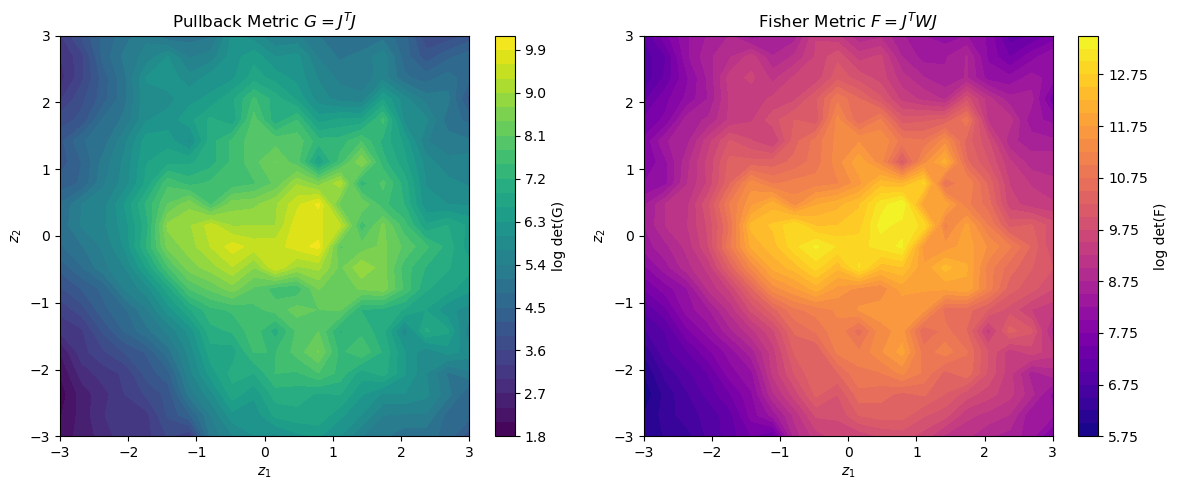

In [16]:
def compute_fisher_metric(model, z, eps_clamp=1e-6):
    """Compute Fisher Information Matrix for Bernoulli decoder"""
    J = compute_jacobian(model, z)  # (batch, 784, d)
    p = model.decode(z)  # (batch, 784)
    p = torch.clamp(p, eps_clamp, 1 - eps_clamp)
    
    # Fisher weights for Bernoulli: 1/(p(1-p))
    weights = 1.0 / (p * (1 - p))  # (batch, 784)
    
    # F = J^T diag(w) J
    weighted_J = J * weights.unsqueeze(-1)  # (batch, 784, d)
    F = torch.bmm(J.transpose(-2, -1), weighted_J)  # (batch, d, d)
    return F

def plot_fisher_vs_pullback(model, grid_size=20, extent=3):
    """Compare Fisher metric vs pullback metric"""
    model.eval()
    zs = torch.linspace(-extent, extent, grid_size)
    Z1, Z2 = torch.meshgrid(zs, zs, indexing='ij')
    z_grid = torch.stack([Z1.flatten(), Z2.flatten()], dim=1).to(device)
    
    det_G, det_F = [], []
    for z in z_grid.split(50):
        G = compute_metric(model, z)
        F = compute_fisher_metric(model, z)
        det_G.append(torch.linalg.det(G).detach().cpu())
        det_F.append(torch.linalg.det(F).detach().cpu())
    
    det_G = torch.cat(det_G).reshape(grid_size, grid_size)
    det_F = torch.cat(det_F).reshape(grid_size, grid_size)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    im0 = axes[0].contourf(Z1.numpy(), Z2.numpy(), torch.log(det_G + 1e-8).numpy(), levels=30, cmap='viridis')
    plt.colorbar(im0, ax=axes[0], label='log det(G)')
    axes[0].set_title('Pullback Metric $G = J^T J$')
    axes[0].set_xlabel('$z_1$'); axes[0].set_ylabel('$z_2$')
    
    im1 = axes[1].contourf(Z1.numpy(), Z2.numpy(), torch.log(det_F + 1e-8).numpy(), levels=30, cmap='plasma')
    plt.colorbar(im1, ax=axes[1], label='log det(F)')
    axes[1].set_title('Fisher Metric $F = J^T W J$')
    axes[1].set_xlabel('$z_1$'); axes[1].set_ylabel('$z_2$')
    
    plt.tight_layout()
    plt.show()

plot_fisher_vs_pullback(model)

## 8. Summary & Key Insights

**Differential geometry** provides a principled framework for understanding VAE latent spaces:

| Concept | Interpretation |
|---------|----------------|
| **Pullback Metric** $G = J^T J$ | Measures how image-space distances map to latent space |
| **Fisher Metric** $F$ | Captures statistical distinguishability of generated distributions |
| **Geodesics** | Shortest paths respecting the learned manifold structure |
| **Curvature** | High curvature ↔ rapid change in decoder (class boundaries) |

**Practical implications:**
- Use geodesic interpolation for smoother, more realistic morphing
- Curvature maps reveal the structure learned by the model
- Fisher metric is more statistically principled for probabilistic models

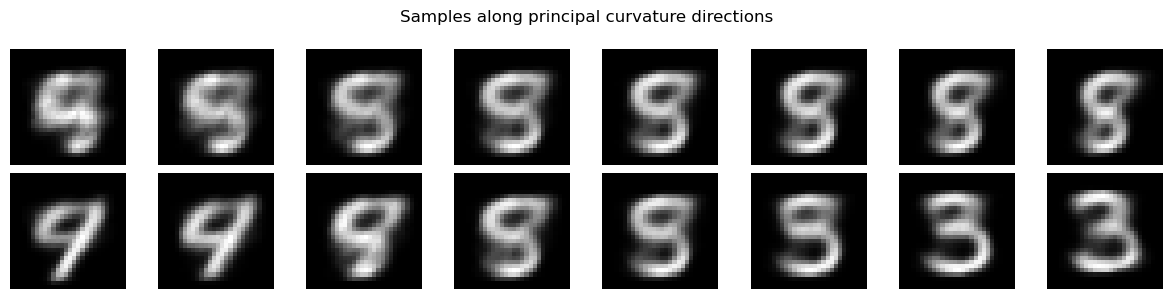

In [17]:
# Bonus: Generate samples along principal curvature directions
def sample_curvature_directions(model, z0, n_samples=8, scale=0.5):
    """Sample along principal directions of the metric tensor"""
    model.eval()
    z0 = z0.to(device).unsqueeze(0)
    G = compute_metric(model, z0)[0].detach()
    
    # Eigendecomposition gives principal directions
    eigenvalues, eigenvectors = torch.linalg.eigh(G)
    
    fig, axes = plt.subplots(2, n_samples, figsize=(n_samples * 1.5, 3))
    
    for dim, (ax_row, ev) in enumerate(zip(axes, eigenvectors.T)):
        t = torch.linspace(-scale, scale, n_samples).to(device)
        samples = z0.squeeze() + t.unsqueeze(1) * ev
        with torch.no_grad():
            imgs = model.decode(samples).cpu().view(-1, 28, 28)
        
        for i, (ax, img) in enumerate(zip(ax_row, imgs)):
            ax.imshow(img, cmap='gray')
            ax.axis('off')
        ax_row[0].set_ylabel(f'PC{dim+1}\n(λ={eigenvalues[dim]:.1f})', fontsize=10)
    
    plt.suptitle('Samples along principal curvature directions', fontsize=12)
    plt.tight_layout()
    plt.show()

# Sample around origin
sample_curvature_directions(model, torch.zeros(2))